# Bayesian neural networks with Pyro

This notebook uses Pyro to train a Bayesian neural network. This notebook is adapted from: https://github.com/paraschopra/bayesian-neural-network-mnist/blob/master/bnn.ipynb and http://pyro.ai/examples/bayesian_regression.html, written by Ben Moseley.

<img src="https://pyro.ai/img/pyro_logo.png" width="100" align="left"/>

# Bayesian neural networks

In the previous part, we used Pyro to define probabilistic models in which their random variables represented **physically relevant features** (such as the weight of an object, and the temperature outside) of the world.

Another possibility is to define a **black-box** probabilistic model, where its (latent or unobserved) random variables do not have physically salient meanings, but its inputs and outputs nonetheless describe meaningful things about the world.

From this viewpoint, we could image a neural network as a probabilistic model, where it's **weights are latent random variables**, and its output is a random variable which depends on the weights and the inputs of the network. More precisely, defining some weights $w$, and input and output variables $x$ and $y$, the neural network is used to model $P(y | w, x)$.

A common choice is to assume this distribution is a Normal distribution, such that

$
P(y | w, x) = \mathcal{N} (y; \mu= f(w,x), \sigma^{2}=1)~,
$

Where $f(w,x)$ is the output of the neural network. In theory, if we define a **prior** on the neural network weights $w$, we could use Pyro (or any PPL) in exactly the same way as we did in the previous part to infer the posterior distribution of the weights $P(w | \mathcal{D})$, given some training data (observations) $\mathcal{D}=\{(x_1,y_1),...(x_n,y_n)\}$. A psuedo-function for the Pyro model would be:

``` 
def model(x, y=None):
    "Pyro BNN model"
    
    w = pyro.sample('w', some-prior-distribution)
    y = pyro.sample('y', dist.Normal(neural-net(w,x), 1), obs=y)
    return y
```

Note, in this approach, $x$ is not considered a random variable (i.e. it is deterministic), but Pyro allows us to pass different values of $x$ to the model by defining it as an input to the stochastic function.

In practice, Pyro provides some additional **high-level features** (in particular, `pyro.nn`) that are useful when defining probabilistic models with neural networks which we will use below.

# The task

Our goal is to classify MNIST images. Crucially, instead of just training a normal neural network, we want to design a network which is able to say when it **doesn't know** the right answer (say, for example when we feed the network an image of letter instead of a number). To do this we will train a Bayesian Neural Network (BNN) in Pyro, and output a predictive posterior distribution over the labels. Example images from MNIST are shown below:

<img src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png" width="500" style="float: none;"/>

This task consists of multiple stages:

- Step 1: load the training/ test data
- Step 2: train a standard NN model
- Step 3: define a BNN model
- Step 4: train the model using SVI
- Step 5: validate the results on test data

In [3]:
import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

#import pyro
#import pyro.distributions as dist
#from pyro.infer import SVI, Trace_ELBO
#from pyro.optim import Adam

from tqdm import tqdm

#pyro.set_rng_seed(101)

## Step 1: load the training/ test data

Below we download the MNIST dataset.

In [4]:
train_dataset = datasets.MNIST('./data', train=True, download=True,
                               transform=transforms.Compose([
                               transforms.ToTensor(),
                               ]))

test_dataset = datasets.MNIST('./data', train=False, download=True,
                              transform=transforms.Compose([
                              transforms.ToTensor(),
                              ]))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=128, shuffle=True)

> **Task 1**: plot a selection of the train/ test images.

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

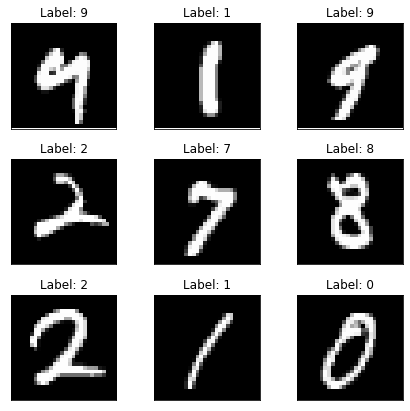

In [10]:

example_data, example_targets = next(iter(train_loader))

example_data = example_data[:9]
example_targets = example_targets[:9]


fig  = plt.figure(figsize = (6,6))
for i in range(9):
    print(example_data[i])
    plt.subplot(3,3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i].view(28,28), cmap = 'gray', interpolation = 'none')
    plt.title("Label: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
              


## Step 2: train a standard NN model

Before we train a BNN, we will train a standard NN classifier to compare our results to. We take the standard approach to classifying MNIST digits using a cross entropy loss, e.g. see here https://github.com/pytorch/examples/blob/master/mnist/main.py : 

In [6]:
class NN(torch.nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, output_size)
        self.relu = torch.nn.ReLU()
        self.log_softmax = torch.nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.log_softmax(x)# output (log) softmax probabilities of each class
        return x

nn = NN(28*28, 512, 10)

> **Task 2**: train this neural network over 5 epochs using the loss function and optimizer given below.

> **Task 3**: report the average prediction accuracy across the test dataset.

In [9]:
loss_function = torch.nn.NLLLoss()# negative log likelihood loss
optimizer = torch.optim.Adam(nn.parameters(), lr=0.01)
num_epochs = 5

## TODO: write some code here

nn.train()
ce_loss = []
precision = []
for epoch in range(num_epochs):
    data_stream = tqdm(enumerate(train_loader, 1), position = 0, leave = True)
    
    for batch_index, (x,y)  in data_stream:
        optimizer.zero_grad()
        print("X", x)
        scores = nn(x)
        print(scores)
        print(y)
        ce_loss = loss_function(scores, y)
        ce_loss.backward()
        optimizer.step()
        
        _, predicted = scores.max(1)
        precision = (predicted == y).sum().float() / len(x)
        
        
        data_stream.set_description((

                    '=> '
                    'epoch: {epoch}/{epochs} | '
                    'progress: [{trained}/{total}] ({progress:.0f}%) | '
                    'prec: {prec:.4} | '
                    'loss => '
                    'ce: {ce_loss:.4} / '
                ).format(
                    epoch=epoch + 1,
                    epochs=num_epochs,
                    trained=batch_index*128,
                    total=len(train_loader.dataset),
                    progress=(100.*batch_index/len(train_loader)),
                    prec=float(precision),
                    ce_loss=float(ce_loss),
                ))
    
     


=> epoch: 1/5 | progress: [768/60000] (1%) | prec: 0.9766 | loss => ce: 0.1382 / : : 3it [00:00, 28.73it/s] 

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [1664/60000] (3%) | prec: 0.9766 | loss => ce: 0.08327 / : : 11it [00:00, 30.55it/s]

tensor([[-1.9508e+01, -3.4124e+01, -1.7422e+01,  ..., -2.4138e-03,
         -1.3170e+01, -8.2408e+00],
        [ 0.0000e+00, -5.8128e+01, -1.9484e+01,  ..., -3.7380e+01,
         -2.3621e+01, -2.6937e+01],
        [-1.7482e+01, -2.6353e+01, -1.8486e+01,  ..., -1.3168e+01,
         -1.7529e+01, -5.2452e-06],
        ...,
        [ 0.0000e+00, -8.8307e+01, -3.9128e+01,  ..., -3.8854e+01,
         -5.4712e+01, -4.4700e+01],
        [-5.0196e+01, -2.8270e+01, -2.1022e+01,  ..., -1.0729e-06,
         -2.1463e+01, -3.6130e+01],
        [-1.9843e+01, -2.3257e+01, -2.2012e+01,  ..., -2.3000e+01,
         -2.3835e+01, -3.5680e+01]], grad_fn=<LogSoftmaxBackward>)
tensor([7, 0, 9, 8, 4, 8, 5, 6, 1, 7, 6, 4, 5, 0, 2, 0, 6, 7, 1, 4, 3, 6, 4, 9,
        5, 8, 8, 9, 6, 3, 1, 1, 0, 5, 1, 0, 1, 2, 3, 5, 9, 0, 3, 2, 4, 9, 2, 4,
        9, 1, 0, 9, 4, 5, 7, 9, 6, 2, 8, 9, 2, 7, 8, 4, 0, 8, 2, 9, 1, 9, 4, 2,
        5, 5, 6, 3, 1, 0, 6, 3, 1, 3, 5, 8, 4, 1, 8, 7, 1, 8, 9, 6, 4, 8, 6, 9,
        6, 2, 8, 7

=> epoch: 1/5 | progress: [2560/60000] (4%) | prec: 0.9688 | loss => ce: 0.1267 / : : 19it [00:00, 31.43it/s] 

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [3456/60000] (6%) | prec: 0.9766 | loss => ce: 0.09021 / : : 27it [00:00, 32.18it/s]

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [4352/60000] (7%) | prec: 0.9609 | loss => ce: 0.2289 / : : 34it [00:01, 32.55it/s] 

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [5120/60000] (9%) | prec: 0.9844 | loss => ce: 0.06978 / : : 38it [00:01, 31.69it/s]

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [5632/60000] (9%) | prec: 0.9844 | loss => ce: 0.06522 / : : 42it [00:01, 28.93it/s]

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [6656/60000] (11%) | prec: 0.9766 | loss => ce: 0.08961 / : : 49it [00:01, 28.36it/s]

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [7424/60000] (12%) | prec: 0.9375 | loss => ce: 0.2095 / : : 57it [00:01, 30.28it/s] 

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

=> epoch: 1/5 | progress: [8192/60000] (14%) | prec: 0.9766 | loss => ce: 0.08114 / : : 61it [00:02, 30.41it/s]

tensor([[-4.0426e+01, -2.0371e+01, -2.0996e+01,  ..., -1.7105e+01,
         -1.5377e+01, -2.0031e+01],
        [-3.1807e+01, -3.1828e-05, -2.2734e+01,  ..., -1.2809e+01,
         -1.6065e+01, -1.0483e+01],
        [-2.6473e+01, -2.3852e+01, -1.9329e+01,  ..., -1.8358e+01,
         -1.4259e+01, -9.0599e-06],
        ...,
        [-6.0742e+01, -4.6963e+01, -4.8326e+01,  ..., -5.2774e+01,
         -3.8979e+01, -4.0536e+01],
        [-1.4582e+01, -1.4097e+01, -9.3969e+00,  ..., -7.5945e+00,
         -1.9957e-03, -7.1873e+00],
        [-4.1312e+01, -3.0603e+01, -3.1323e+01,  ..., -2.2487e+01,
         -1.5190e+01, -1.6419e+01]], grad_fn=<LogSoftmaxBackward>)
tensor([3, 1, 9, 8, 5, 1, 4, 3, 1, 9, 1, 6, 9, 3, 0, 9, 1, 0, 9, 1, 5, 3, 9, 8,
        3, 5, 1, 0, 5, 3, 2, 0, 7, 6, 6, 9, 7, 4, 2, 7, 1, 8, 7, 3, 2, 4, 5, 5,
        8, 9, 7, 2, 4, 5, 1, 8, 1, 0, 0, 5, 7, 3, 4, 5, 5, 0, 6, 3, 4, 2, 3, 7,
        0, 1, 4, 7, 2, 7, 8, 2, 3, 8, 8, 6, 3, 1, 7, 7, 2, 1, 1, 7, 7, 7, 3, 9,
        3, 7, 0, 1

=> epoch: 1/5 | progress: [9216/60000] (15%) | prec: 0.9766 | loss => ce: 0.07527 / : : 69it [00:02, 30.99it/s]

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [9984/60000] (17%) | prec: 0.9844 | loss => ce: 0.06209 / : : 77it [00:02, 30.35it/s]

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [10752/60000] (18%) | prec: 0.9766 | loss => ce: 0.05826 / : : 81it [00:02, 29.98it/s]

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [11520/60000] (19%) | prec: 0.9844 | loss => ce: 0.03072 / : : 89it [00:02, 29.82it/s]

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [12416/60000] (21%) | prec: 0.9688 | loss => ce: 0.04281 / : : 97it [00:03, 29.67it/s]

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [13184/60000] (22%) | prec: 0.9688 | loss => ce: 0.06132 / : : 100it [00:03, 29.51it/s]

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [13952/60000] (23%) | prec: 0.9922 | loss => ce: 0.08121 / : : 108it [00:03, 30.32it/s]

tensor([[-1.2630e+01, -6.2400e+00, -1.2394e+01,  ..., -7.2150e+00,
         -6.1245e+00, -6.9256e-03],
        [-6.3210e+00, -1.3689e+01, -1.1145e+01,  ..., -1.7914e+01,
         -2.3073e-03, -1.1451e+01],
        [-2.3727e+01, -2.3246e-05, -1.6733e+01,  ..., -1.4207e+01,
         -1.2255e+01, -1.5336e+01],
        ...,
        [-1.9698e+01, -3.5763e-06, -1.9644e+01,  ..., -1.2889e+01,
         -1.5345e+01, -1.4745e+01],
        [-1.4217e+01, -8.7163e+00, -2.0145e+01,  ..., -1.3221e+01,
         -1.3142e+01, -7.7801e-04],
        [-2.8386e+01, -2.9802e-06, -1.7648e+01,  ..., -1.6677e+01,
         -1.3525e+01, -2.1084e+01]], grad_fn=<LogSoftmaxBackward>)
tensor([9, 8, 1, 7, 7, 8, 9, 1, 1, 2, 2, 8, 8, 0, 7, 4, 0, 8, 3, 9, 7, 3, 2, 2,
        6, 8, 5, 1, 8, 1, 1, 7, 2, 6, 8, 9, 7, 7, 8, 1, 6, 6, 1, 7, 5, 8, 2, 5,
        8, 0, 9, 7, 1, 1, 1, 4, 3, 0, 6, 8, 8, 8, 7, 4, 6, 9, 7, 5, 2, 8, 1, 1,
        6, 9, 6, 0, 1, 2, 0, 4, 8, 3, 0, 0, 7, 4, 4, 0, 1, 0, 3, 4, 5, 5, 0, 9,
        7, 1, 6, 6

=> epoch: 1/5 | progress: [14848/60000] (25%) | prec: 0.9844 | loss => ce: 0.06972 / : : 115it [00:03, 28.97it/s]

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [15744/60000] (26%) | prec: 0.9766 | loss => ce: 0.06828 / : : 123it [00:04, 30.72it/s]

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [16512/60000] (28%) | prec: 0.9531 | loss => ce: 0.1267 / : : 127it [00:04, 31.21it/s] 

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [17280/60000] (29%) | prec: 0.9609 | loss => ce: 0.1687 / : : 134it [00:04, 29.66it/s] 

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

=> epoch: 1/5 | progress: [18048/60000] (30%) | prec: 0.9375 | loss => ce: 0.397 / : : 138it [00:04, 30.28it/s]  

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [18944/60000] (32%) | prec: 0.9766 | loss => ce: 0.06502 / : : 146it [00:04, 31.27it/s]

tensor([2, 9, 2, 3, 1, 5, 7, 4, 7, 1, 2, 9, 9, 2, 3, 2, 9, 5, 0, 5, 8, 8, 7, 9,
        5, 7, 2, 2, 3, 2, 8, 3, 1, 8, 8, 4, 7, 8, 7, 0, 6, 1, 9, 2, 5, 1, 2, 4,
        5, 6, 9, 3, 7, 8, 4, 8, 1, 4, 6, 3, 7, 7, 1, 4, 6, 2, 9, 0, 9, 1, 7, 1,
        0, 1, 1, 6, 9, 8, 5, 8, 3, 1, 1, 0, 2, 6, 6, 7, 9, 0, 2, 2, 4, 9, 4, 8,
        9, 0, 8, 6, 2, 1, 7, 8, 6, 4, 0, 7, 5, 2, 9, 5, 4, 8, 5, 7, 7, 0, 5, 1,
        4, 7, 6, 8, 8, 0, 2, 4])
X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0., 

=> epoch: 1/5 | progress: [19712/60000] (33%) | prec: 0.9844 | loss => ce: 0.1145 / : : 154it [00:05, 31.03it/s] 

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [20480/60000] (34%) | prec: 0.9609 | loss => ce: 0.07547 / : : 158it [00:05, 30.08it/s]

tensor([4, 2, 7, 3, 4, 9, 1, 3, 5, 9, 2, 7, 8, 9, 4, 1, 8, 9, 4, 4, 6, 5, 2, 1,
        6, 1, 8, 2, 6, 3, 5, 0, 2, 4, 7, 8, 2, 4, 2, 8, 5, 0, 2, 9, 4, 9, 0, 8,
        7, 7, 3, 4, 1, 9, 9, 6, 4, 0, 7, 8, 4, 5, 1, 1, 2, 0, 1, 1, 5, 3, 1, 7,
        0, 9, 3, 7, 0, 9, 3, 4, 0, 6, 9, 2, 6, 4, 3, 5, 2, 2, 2, 3, 9, 4, 3, 4,
        5, 6, 9, 0, 7, 4, 8, 7, 5, 7, 8, 6, 4, 4, 5, 6, 4, 4, 1, 1, 2, 1, 1, 8,
        9, 5, 1, 1, 8, 7, 1, 3])
X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0., 

=> epoch: 1/5 | progress: [21248/60000] (35%) | prec: 0.9609 | loss => ce: 0.2105 / : : 165it [00:05, 29.37it/s] 

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [22016/60000] (37%) | prec: 0.9844 | loss => ce: 0.04934 / : : 169it [00:05, 29.94it/s]

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [22784/60000] (38%) | prec: 0.9844 | loss => ce: 0.02856 / : : 176it [00:05, 27.74it/s]

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

=> epoch: 1/5 | progress: [23680/60000] (39%) | prec: 0.9688 | loss => ce: 0.2472 / : : 184it [00:06, 30.14it/s] 

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [24448/60000] (41%) | prec: 0.9766 | loss => ce: 0.06186 / : : 188it [00:06, 29.21it/s]

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [25216/60000] (42%) | prec: 0.9688 | loss => ce: 0.09675 / : : 196it [00:06, 30.28it/s]

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [25856/60000] (43%) | prec: 0.9219 | loss => ce: 0.4121 / : : 200it [00:06, 27.62it/s] 

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [26880/60000] (45%) | prec: 0.9766 | loss => ce: 0.07419 / : : 208it [00:06, 30.23it/s]

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [27776/60000] (46%) | prec: 0.9844 | loss => ce: 0.07516 / : : 216it [00:07, 31.27it/s]

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [28544/60000] (48%) | prec: 0.9688 | loss => ce: 0.1199 / : : 220it [00:07, 31.95it/s] 

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [29568/60000] (49%) | prec: 0.9688 | loss => ce: 0.1182 / : : 228it [00:07, 32.96it/s] 

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [30464/60000] (51%) | prec: 0.9453 | loss => ce: 0.1497 / : : 236it [00:07, 32.87it/s] 

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [31232/60000] (52%) | prec: 0.9688 | loss => ce: 0.1286 / : : 244it [00:07, 33.13it/s] 

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [32128/60000] (54%) | prec: 0.9609 | loss => ce: 0.1048 / : : 248it [00:08, 31.50it/s] 

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [32896/60000] (55%) | prec: 0.9844 | loss => ce: 0.03793 / : : 256it [00:08, 30.98it/s]

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [33536/60000] (56%) | prec: 0.9922 | loss => ce: 0.02053 / : : 260it [00:08, 28.76it/s]

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [34432/60000] (57%) | prec: 0.9609 | loss => ce: 0.1737 / : : 267it [00:08, 29.25it/s] 

tensor([[-2.8921e+01, -2.0327e+01, -9.7407e+00,  ..., -1.7458e+01,
         -1.3583e+01, -1.1275e+01],
        [-2.8061e+01, -2.8837e+01, -2.1296e+01,  ..., -2.3812e+01,
         -1.6738e+01, -4.7342e+00],
        [-2.5446e+01, -2.0959e+01, -1.9362e+01,  ..., -2.0924e+01,
         -6.4490e-05, -1.6086e+01],
        ...,
        [-2.4677e+01, -9.8027e+00, -8.0582e-05,  ..., -1.0585e+01,
         -2.6851e+01, -5.3753e+01],
        [-1.3050e+01, -1.3440e+01, -8.1112e+00,  ..., -1.0076e+01,
         -1.2145e+00, -8.9254e+00],
        [-2.9170e+01, -3.6372e+01, -2.5408e+01,  ..., -3.1067e+01,
         -2.7800e+01, -3.2187e+01]], grad_fn=<LogSoftmaxBackward>)
tensor([4, 4, 8, 5, 0, 8, 8, 0, 6, 2, 9, 4, 8, 6, 7, 9, 9, 2, 9, 1, 6, 6, 9, 5,
        8, 9, 9, 0, 0, 1, 6, 2, 7, 9, 9, 1, 5, 1, 7, 8, 9, 1, 7, 0, 6, 6, 3, 9,
        2, 0, 2, 6, 3, 6, 7, 8, 1, 5, 9, 4, 6, 8, 8, 7, 0, 7, 9, 5, 3, 8, 2, 8,
        6, 1, 6, 2, 1, 2, 6, 9, 2, 9, 1, 0, 4, 6, 5, 8, 6, 4, 4, 1, 4, 7, 4, 4,
        7, 8, 6, 6

=> epoch: 1/5 | progress: [35200/60000] (59%) | prec: 0.9844 | loss => ce: 0.08504 / : : 275it [00:09, 29.99it/s]

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [35968/60000] (60%) | prec: 0.9609 | loss => ce: 0.1629 / : : 279it [00:09, 28.87it/s] 

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [36864/60000] (61%) | prec: 0.9766 | loss => ce: 0.04913 / : : 287it [00:09, 30.49it/s]

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [37760/60000] (63%) | prec: 0.9609 | loss => ce: 0.1439 / : : 295it [00:09, 32.14it/s] 

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [38528/60000] (64%) | prec: 0.9844 | loss => ce: 0.02707 / : : 299it [00:09, 31.94it/s]

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [39552/60000] (66%) | prec: 0.9766 | loss => ce: 0.2467 / : : 307it [00:10, 31.50it/s] 

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [40448/60000] (67%) | prec: 0.9922 | loss => ce: 0.06769 / : : 315it [00:10, 32.66it/s]

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [41344/60000] (69%) | prec: 0.9922 | loss => ce: 0.02029 / : : 323it [00:10, 33.08it/s]

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [42112/60000] (70%) | prec: 0.9844 | loss => ce: 0.06765 / : : 327it [00:10, 32.60it/s]

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [43008/60000] (72%) | prec: 0.9531 | loss => ce: 0.1863 / : : 335it [00:10, 30.68it/s] 

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [43776/60000] (73%) | prec: 0.9766 | loss => ce: 0.1981 / : : 339it [00:11, 30.44it/s] 

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [44544/60000] (74%) | prec: 0.9453 | loss => ce: 0.1598 / : : 347it [00:11, 29.82it/s] 

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [45312/60000] (75%) | prec: 0.9453 | loss => ce: 0.2748 / : : 351it [00:11, 29.38it/s] 

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

=> epoch: 1/5 | progress: [46208/60000] (77%) | prec: 0.9766 | loss => ce: 0.07165 / : : 359it [00:11, 30.35it/s]

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

=> epoch: 1/5 | progress: [47104/60000] (78%) | prec: 0.9922 | loss => ce: 0.01577 / : : 367it [00:12, 30.74it/s]

tensor([[-1.5439e+01, -2.2610e+01, -8.7136e+00,  ..., -1.6362e+01,
         -2.3112e-04, -1.6688e+01],
        [-2.9996e+01, -1.4332e+01, -1.8407e+01,  ..., -1.0647e+01,
         -2.5620e+01, -1.2754e+01],
        [-2.1876e+01, -1.2550e+01, -5.1437e-04,  ..., -7.5840e+00,
         -1.8526e+01, -4.7668e+01],
        ...,
        [-3.1785e+01, -2.3963e+01, -1.6129e+01,  ..., -2.5536e+01,
         -2.8614e+01, -2.3932e+01],
        [-4.4534e+01, -5.7220e-06, -2.3518e+01,  ..., -1.3114e+01,
         -1.7395e+01, -2.0388e+01],
        [-2.9587e+01, -6.1143e+01, -1.3318e+01,  ..., -2.1219e+01,
         -1.4584e+01, -4.7899e+00]], grad_fn=<LogSoftmaxBackward>)
tensor([8, 4, 2, 5, 6, 4, 0, 2, 9, 0, 1, 2, 2, 0, 7, 4, 6, 2, 5, 7, 5, 5, 5, 4,
        4, 5, 2, 8, 6, 4, 3, 1, 1, 0, 4, 5, 3, 9, 8, 6, 2, 2, 1, 9, 1, 9, 7, 2,
        0, 9, 4, 8, 2, 3, 6, 0, 9, 2, 1, 2, 0, 9, 3, 8, 2, 1, 2, 0, 2, 5, 7, 8,
        6, 1, 6, 5, 0, 5, 6, 9, 3, 6, 7, 0, 6, 8, 7, 0, 5, 1, 0, 1, 9, 7, 8, 2,
        5, 0, 4, 6

=> epoch: 1/5 | progress: [47488/60000] (79%) | prec: 0.9844 | loss => ce: 0.0389 / : : 371it [00:12, 30.48it/s] 

X tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 

KeyboardInterrupt: 

In [6]:
nn.train(mode = False)  
total_tested = 0
total_correct = 0

for x,y in test_loader:
    scores = nn(x)
    _, predicted = scores.max(1)
    
    total_correct += int((predicted == y).sum())
    total_tested += len(x)
precision = total_correct/ total_tested

print('Test set precision: ', precision)
    

Test set precision:  0.9657


### Testing outside of the training distribution

Next, we plot the predictions of the standard NN outside of its training distribution: i.e. on images which we expect the NN should not know the right answer.

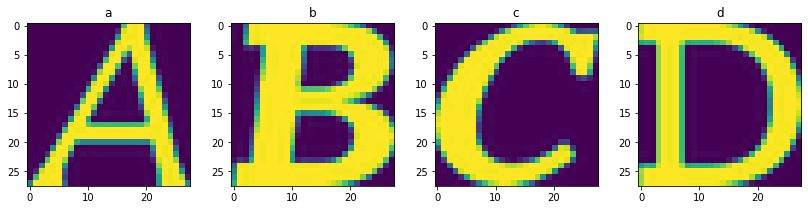

In [7]:
# load the test letter dataset
letters = ["a","b","c","d","e","f","g","h","i","j"]
x_letters = np.array([np.array(Image.open("data/not-mnist/%s.png"%(l)))
                         for l in letters]).astype(np.float32)# loads letters data
x_letters /= np.max(x_letters, axis=(1,2), keepdims=True)# normalise
x_letters = torch.from_numpy(x_letters)

# plot the letters test data
plt.figure(figsize=(14,3))
for iplot,i in enumerate([0,1,2,3]):
    plt.subplot(1,4,iplot+1)
    plt.imshow(x_letters[i].numpy())
    plt.title(letters[i])
plt.show()

> **Task 4**: plot the predicted softmax probability distribution over each class for each of these test letters.

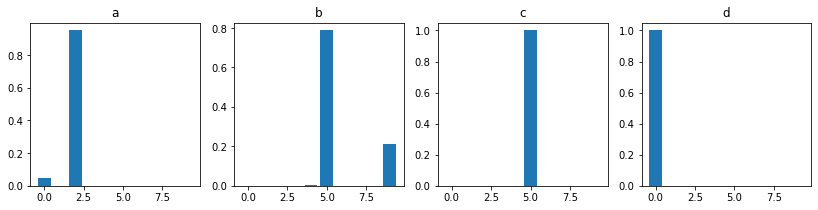

In [8]:
## TODO: write some code here
probs = []
for letter in x_letters:
    log_probabilities = nn(letter).detach().numpy()[0]
    probabilities = [np.exp(prob) for prob in log_probabilities]
    probs.append(probabilities)
    
x = np.arange(10)
width = 0.7

plt.figure(figsize=(14,3))
for iplot,i in enumerate([0,1,2,3]):
    plt.subplot(1,4,iplot+1)
    plt.bar(x, probs[i])
    plt.title(letters[i])
plt.show()

#Model is very certain about its prediction as the probabilities are very high

## Step 3: define a BNN model

It appears the standard network makes *overconfident predictions* on the test data outside of its training distribution.

Note, from a probabilistic perspective, the code above defines a neural network which models the labels as a categorical distribution, and the network is trained by maximising the log-likelihood of the training data. i.e., we are making an MLE point estimate of the trainable parameters of the network.

This doesn't require specifying a prior over the parameters of the network, nor does it model the full posterior distribution over the parameters (instead it just gives us a point estimate).

Instead, we will train a BNN using Pyro to do the same task, this time specifying priors over the parameters, and approximating their full posterior distribution using SVI.

In [9]:
PyroLinear = pyro.nn.PyroModule[torch.nn.Linear]
    
class BNN(pyro.nn.PyroModule):
    
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        
        self.fc1 = PyroLinear(input_size, hidden_size)
        self.fc1.weight = pyro.nn.PyroSample(dist.Normal(0., 1.).expand([hidden_size, input_size]))
        self.fc1.bias   = pyro.nn.PyroSample(dist.Normal(0., 1.).expand([hidden_size]))
        
        self.fc2 = PyroLinear(hidden_size, output_size)
        self.fc2.weight = pyro.nn.PyroSample(dist.Normal(0., 1.).expand([output_size, hidden_size]))
        self.fc2.bias   = pyro.nn.PyroSample(dist.Normal(0., 1.).expand([output_size]))
        
        self.relu = torch.nn.ReLU()
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, y=None):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.log_softmax(x)# output (log) softmax probabilities of each class
        
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Categorical(logits=x), obs=y)
            
bnn = BNN(28*28, 512, 10)
print(bnn)

BNN(
  (fc1): PyroLinear(in_features=784, out_features=512, bias=True)
  (fc2): PyroLinear(in_features=512, out_features=10, bias=True)
  (relu): ReLU()
  (log_softmax): LogSoftmax(dim=1)
)


The code above is the Pyro BNN equivalent to the PyTorch NN class defined above.

There is a lot going on, and we break this down below:
- Instead of defining *stochastic functions*, Pyro allows us to define *stochastic modules* as probabilistic models. We can think of these as an extension of PyTorch's `nn.Module` class, allowing us to use the same idiom but enabling their Bayesian treatment with Pyro.
- We can "Pyro-ize" an existing PyTorch module by using the `pyro.nn.PyroModule[torch.nn.Linear]` metaclass constructor, or by subclassing `pyro.nn.PyroModule`. All modules in the model need to be "Pyro-ized" for this to be a valid Pyro module.

We define the network in a very similar way, except for some important changes:
- We turn the weights and biases into random variables by using `pyro.nn.PyroSample`: this is the equivalent of `pyro.sample` for creating stochastic `pyro.nn.PyroModule` attributes. Now, every time we call `.forward` above, a new set of weights and biases are sampled from their prior distributions. Note whilst `pyro.sample` requires a name string, Pyro handles the naming of `pyro.nn.PyroSample` attributes automatically.
- The `.expand([hidden_size, input_size])` allows us to define multiple univariate distributions which are conditionally independent.
- The `pyro.plate` context manager allows us to explicitly state that the observations are conditionally independent across the batch dimension of the network's inputs, which can speed up the underlying inference.
- Note the basic elements of a Pyro model are present: we define some unobserved random variables (the weights and biases of the network), and an observed random variable (the output of the network), using the `obs=` argument.

For more on `pyro.nn.PyroModule`, see: http://pyro.ai/examples/tensor_shapes.html and http://pyro.ai/examples/modules.html.

> **Task 5**: Define a SVI guide function to train the BNN. Define separate (independent) univariate normal distributions for each parameter.

Hint: the name strings automatically assigned to the BNN's parameters are: `"fc1.weight"`, `"fc1.bias"`, `"fc2.weight"`, and `"fc2.bias"`.

In [10]:
def guide(x, y=None):
 
    # here, we define Q as a normal distribution, with flexible (trainable) parameters a and b

    a1_mean = pyro.param("a1_mean", torch.randn_like(bnn.fc1.weight))
    a1_scale = pyro.param("a1_scale", torch.randn_like(bnn.fc1.weight))
    fc1w_prior = dist.Normal(a1_mean, torch.abs(a1_scale))
    
    a2_mean = pyro.param("a2_mean", torch.randn_like(bnn.fc1.bias))
    a2_scale = pyro.param("a2_scale", torch.randn_like(bnn.fc1.bias))
    fc1b_prior = dist.Normal(a2_mean, torch.abs(a2_scale))
    
    
    a3_mean = pyro.param("a3_mean", torch.randn_like(bnn.fc2.weight))
    a3_scale = pyro.param("a3_scale", torch.randn_like(bnn.fc2.weight))
    fc2w_prior = dist.Normal(a3_mean, torch.abs(a3_scale))
    
    a4_mean = pyro.param("a4_mean",  torch.randn_like(bnn.fc2.bias))
    a4_scale = pyro.param("a4_scale",  torch.randn_like(bnn.fc2.bias))
    fc2b_prior = dist.Normal(a4_mean, torch.abs(a4_scale))
    
    
    pyro.sample("fc1.weight", dist.Normal(a1_mean, torch.abs(a1_scale)))
    pyro.sample("fc1.bias", dist.Normal(a2_mean, torch.abs(a2_scale)))
    pyro.sample("fc2.weight", dist.Normal(a3_mean, torch.abs(a3_scale)))
    pyro.sample("fc2.bias", dist.Normal(a4_mean, torch.abs(a4_scale)))

### Autoguides

Note, Pyro makes defining guides even easier with autoguides: for example, we could have achieved a similar guide using `guide = pyro.infer.autoguide.AutoDiagonalNormal(bnn)` above. See here for more info: http://docs.pyro.ai/en/stable/infer.autoguide.html

In [11]:
#guide = pyro.infer.autoguide.AutoDiagonalNormal(bnn)

### On the guide approximation

Note, assuming independent distributions for each set of parameters is quite a strong assumption, and could lead to a poor posterior approximation; see here for a discussion: http://pyro.ai/examples/bayesian_regression_ii.html

## Step 4: train the model using SVI

Finally, we are ready to train the model. This is very similar to training the models using SVI from the previous part.

> **Task 6**: train the BNN, using the optimizer and network structure defined below.

Hint: we can pass training data to SVI using `svi.step(x, y)`.

In [12]:
pyro.clear_param_store()
svi = SVI(model=bnn, 
          guide=guide, 
          optim=Adam({"lr": 1e-2}), 
          loss=Trace_ELBO(num_particles=1))
num_epochs = 5

## TODO: write some code here

epoch_loss = 0
data_len = len(train_loader.dataset)
for epoch in range(num_epochs):
    loss = 0
    data_stream = tqdm(enumerate(train_loader, 1), position = 0, leave = True)
    for batch_index, (x,y)  in data_stream:
        loss= svi.step(x, y)
        epoch_loss+= loss
        
        data_stream.set_description((

                    '=> '
                    'epoch: {epoch}/{epochs} | '
                    'progress: [{trained}/{total}] ({progress:.0f}%) | '
                    'loss => '
                    'ELBO: {loss:.4} / '
                ).format(
                    epoch=epoch + 1,
                    epochs=num_epochs,
                    trained=batch_index*128,
                    total=len(train_loader.dataset),
                    progress=(100.*batch_index/len(train_loader)),
                    loss=float(loss),
                ))
    epoch_loss/=data_len
    print(epoch_loss)


=> epoch: 1/5 | progress: [60032/60000] (100%) | loss => ELBO: 4.134e+04 / : : 469it [00:37, 12.39it/s]
=> epoch: 2/5 | progress: [256/60000] (0%) | loss => ELBO: 4.149e+04 / : : 2it [00:00, 12.36it/s]

1034.0866284925937


=> epoch: 2/5 | progress: [60032/60000] (100%) | loss => ELBO: 1.41e+04 / : : 469it [00:39, 11.81it/s] 
=> epoch: 3/5 | progress: [256/60000] (0%) | loss => ELBO: 1.465e+04 / : : 1it [00:00,  9.88it/s]

189.722554225406


=> epoch: 3/5 | progress: [60032/60000] (100%) | loss => ELBO: 8.84e+03 / : : 469it [00:40, 11.71it/s] 
=> epoch: 4/5 | progress: [256/60000] (0%) | loss => ELBO: 8.949e+03 / : : 2it [00:00, 12.74it/s]

85.60387189030678


=> epoch: 4/5 | progress: [60032/60000] (100%) | loss => ELBO: 6.535e+03 / : : 469it [00:34, 13.42it/s]
=> epoch: 5/5 | progress: [128/60000] (0%) | loss => ELBO: 7.441e+03 / : : 1it [00:00,  7.24it/s]

62.63006410294487


=> epoch: 5/5 | progress: [60032/60000] (100%) | loss => ELBO: 6.076e+03 / : : 469it [00:38, 12.11it/s]

56.20265316092327


> **Task 7**: report the average prediction accuracy across the test dataset.

Hint: we can use `predictive = pyro.infer.Predictive(model=bnn, guide=guide, num_samples=10)` to obtain a function that will sample from the predictive posterior distribution of the BNN, given an input `x` (i.e. it calls .forward using network parameters sampled from the guide). You can take the mode of the predicted class samples to be the network prediction.

In [13]:
## TODO: write some code here
predictive = pyro.infer.Predictive(model=bnn, guide=guide, num_samples=10)
correct = 0
total = 0
for i, (x,y) in enumerate(test_loader):
    predicted = predictive(x)['obs']    
    mode = torch.mode(predicted, dim = 0).values
    correct += (mode == y).sum().item()
    total += y.size(0)
    
print('Accuracy: %d %%' % (100 * correct /total))
    
    



Accuracy: 85 %


## Step 5: validate the results on test data

Now we are ready to test the predictions of the BNN on the letters dataset. You should find that the network is much more uncertain about its predictions!

> **Task 8**: plot the predictive posterior distribution over each class for each of the test letters.

Hint: we can again use `predictive` to draw samples from the predictive posterior distribution. You can estimate the distribution by plotting the histogram of counts in each class for each letter.

<Figure size 1008x216 with 0 Axes>

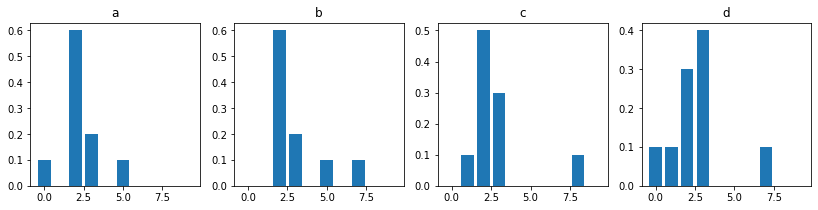

In [14]:
from collections import Counter
## TODO: write some code here

plt.figure(figsize=(14,3))
width = 0.7
x = range(10)

plt.figure(figsize=(14,3))
for iplot,i in enumerate([0,1,2,3]):
    predicted = predictive(letter)['obs'].squeeze(1).tolist()
    counts = Counter(predicted)
    
    frequencies = counts.values()
    names = counts.keys()
    probs = []
    for j in range(10):
        if counts[j] == 0:
            probs.append(0)
        else:
            probs.append(counts[j]/10)
    plt.subplot(1,4,iplot+1)
    plt.bar(x, probs)
    plt.title(letters[i])
    
plt.show()


## Possible extensions

We mentioned above that our SVI implementation makes a strong assumption about the form of the posterior distribution. Here are a few possible extension questions/ tasks:

> **(Extension) Question 1**: What other guide functions could you use? How does their computational complexity scale?

> **(Extension) Question 2**: How would MCMC methods (e.g. HMC) cope for this problem?

> **(Extension) Task 1**: Try experimenting with other guides in: http://docs.pyro.ai/en/stable/infer.autoguide.html  such as `AutoLowRankMultivariateNormal`.

In [15]:
#AutoDiagonalNormal assumes that there is no correlation between the latent variables
#by using a diagonal covaraicne matrix. Instead using e.g. Auto(LowRank)MultivariateNormal 
#we can model dependencies among the latent variables. But computational complexity scales 
#quadratically.

#MCMC draw unbiased samples from the true posterior in the limit of infinite data
#Therefore, it does not make and independece assumptions and is more accurate
#if enough data is provided

In [16]:
#somehow my kernel dies when I try to run this ... or I run out of memory with AutoMultivariateNormal
'''
guide = pyro.infer.autoguide.AutoLowRankMultivariateNormal(bnn) 

pyro.clear_param_store()
svi = SVI(model=bnn, 
          guide=guide, 
          optim=Adam({"lr": 1e-2}), 
          loss=Trace_ELBO(num_particles=1))
num_epochs = 5

## TODO: write some code here

epoch_loss = 0
data_len = len(train_loader.dataset)
for epoch in range(num_epochs):
    loss = 0
    data_stream = tqdm(enumerate(train_loader, 1), position = 0, leave = True)
    for batch_index, (x,y)  in data_stream:
        loss= svi.step(x, y)
        epoch_loss+= loss
        
        data_stream.set_description((

                    '=> '
                    'epoch: {epoch}/{epochs} | '
                    'progress: [{trained}/{total}] ({progress:.0f}%) | '
                    'loss => '
                    'ELBO: {loss:.4} / '
                ).format(
                    epoch=epoch + 1,
                    epochs=num_epochs,
                    trained=batch_index*128,
                    total=len(train_loader.dataset),
                    progress=(100.*batch_index/len(train_loader)),
                    loss=float(loss),
                ))
    epoch_loss/=data_len
    print(epoch_loss)
'''

'\nguide = pyro.infer.autoguide.AutoLowRankMultivariateNormal(bnn) \n\npyro.clear_param_store()\nsvi = SVI(model=bnn, \n          guide=guide, \n          optim=Adam({"lr": 1e-2}), \n          loss=Trace_ELBO(num_particles=1))\nnum_epochs = 5\n\n## TODO: write some code here\n\nepoch_loss = 0\ndata_len = len(train_loader.dataset)\nfor epoch in range(num_epochs):\n    loss = 0\n    data_stream = tqdm(enumerate(train_loader, 1), position = 0, leave = True)\n    for batch_index, (x,y)  in data_stream:\n        loss= svi.step(x, y)\n        epoch_loss+= loss\n        \n        data_stream.set_description((\n\n                    \'=> \'\n                    \'epoch: {epoch}/{epochs} | \'\n                    \'progress: [{trained}/{total}] ({progress:.0f}%) | \'\n                    \'loss => \'\n                    \'ELBO: {loss:.4} / \'\n                ).format(\n                    epoch=epoch + 1,\n                    epochs=num_epochs,\n                    trained=batch_index*128,\n 